In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, autograd
from torch.nn import functional as F

import numpy as np
import scipy.spatial
import math

In [2]:

Dx = 2
N = 10000

X0 = torch.randn(N, Dx)
X1 = X0 + torch.randn(N, Dx)




# Dx_bar = 2
# N = 10000
# X0_bar = torch.randn(N, Dx_bar)
# X0_bar[:, 1] = X0_bar[:, 0] + torch.randn_like(X0_bar[:, 0])
# X1_bar = torch.empty(N, Dx_bar)
# X1_bar[:, 0] = X0_bar[:, 0] + torch.randn(N)
# X1_bar[:, 1] = X1_bar[:, 0] + torch.randn_like(X1_bar[:, 0])

# Dx = 10
# W = torch.rand(Dx, 2) * 2 - 1
# b = torch.rand(Dx) * 2
# X0 = torch.exp(-0.5*(torch.mm(X0_bar, W.T) + b)**2)
# X1 = torch.exp(-0.5*(torch.mm(X1_bar, W.T) + b)**2)

Dy = Dx//2
Y0 = X0[:,0].reshape(-1,1)
Y1 = X1[:,0].reshape(-1,1)

In [3]:
print(Y0.size())

torch.Size([10000, 1])


In [4]:
train_batch_size = 128

train_loader = torch.utils.data.DataLoader(
    torch.cat([X0, X1, Y1], 1), batch_size = train_batch_size, shuffle = True)

In [5]:
Dr = 1


R_net = nn.Sequential(
    nn.Linear(Dx, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, Dr)
    )

T_net = nn.Sequential(
    nn.Linear(2*Dr + Dy, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
    )

Tx_net = nn.Sequential(
    nn.Linear(Dx + Dr + Dy, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
    )

In [6]:
lr = 1e-3
optimizer_max = optim.Adam(list(R_net.parameters()) + list(T_net.parameters()), lr=lr)
scheduler_max = torch.optim.lr_scheduler.StepLR(optimizer_max, step_size=25, gamma=0.1)

optimizer_min = optim.Adam(list(Tx_net.parameters()), lr=lr)
scheduler_min = torch.optim.lr_scheduler.StepLR(optimizer_min, step_size=25, gamma=0.1)

n_epochs = 50
train_data_size = len(train_loader.dataset)
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):

        actual_size = len(data)
        data = data
        data_X0 = data[:, :Dx]
        data_X1 = data[:, Dx:2*Dx]
        data_Y1 = data[:, 2*Dx:]

        
        #rand_ind = np.random.choice(train_data_size, actual_size, replace=False)
        #data_iX1 = train_loader.dataset[rand_ind, Dx:2*Dx].to(device)
        data_iX1 = data_X1[torch.randperm(actual_size)]
        data_iY1 = data_Y1[torch.randperm(actual_size)]
        R0 = R_net(data_X0)
        R1 = R_net(data_X1)
        iR1 = R_net(data_iX1)
        T_J = T_net(torch.cat([R0, R1, data_Y1], 1))
        T_I = T_net(torch.cat([R0, iR1, data_iY1], 1))
        T_loss = -T_J.mean() + torch.logsumexp(T_I, 0)[0]

        train_loss += T_loss.item() * len(data)
        optimizer_max.zero_grad()
        T_loss.backward()
        optimizer_max.step()
        
        R1 = R_net(data_X1)
        iR1 = R_net(data_iX1)
        Tx_J = Tx_net(torch.cat([data_X0, R1, data_Y1], 1))
        Tx_I = Tx_net(torch.cat([data_X0, iR1, data_iY1], 1))
        Tx_loss = -Tx_J.mean() + torch.logsumexp(Tx_I, 0)[0]
        
        train_loss += Tx_loss.item() * len(data)
        optimizer_min.zero_grad()
        Tx_loss.backward()
        optimizer_min.step()

    train_loss /= len(train_loader.dataset)
    
    if epoch % 1 == 0:
        print('Train Epoch: {} ===> Train set loss: {:.4f}'.format(epoch, train_loss))
    
    scheduler_max.step()
    scheduler_min.step()

Train Epoch: 1 ===> Train set loss: 7.6730
Train Epoch: 2 ===> Train set loss: 5.3159
Train Epoch: 3 ===> Train set loss: 4.7181
Train Epoch: 4 ===> Train set loss: 3.7233
Train Epoch: 5 ===> Train set loss: 4.0367
Train Epoch: 6 ===> Train set loss: 3.9469
Train Epoch: 7 ===> Train set loss: 4.0237
Train Epoch: 8 ===> Train set loss: 3.6409
Train Epoch: 9 ===> Train set loss: 3.6459
Train Epoch: 10 ===> Train set loss: 4.0597
Train Epoch: 11 ===> Train set loss: 3.3616
Train Epoch: 12 ===> Train set loss: 3.9065
Train Epoch: 13 ===> Train set loss: 2.5297
Train Epoch: 14 ===> Train set loss: 5.9016
Train Epoch: 15 ===> Train set loss: 5.1207
Train Epoch: 16 ===> Train set loss: 3.4326
Train Epoch: 17 ===> Train set loss: 4.0227
Train Epoch: 18 ===> Train set loss: 2.8385
Train Epoch: 19 ===> Train set loss: 4.2503
Train Epoch: 20 ===> Train set loss: 3.8454
Train Epoch: 21 ===> Train set loss: 5.1645
Train Epoch: 22 ===> Train set loss: 3.8362
Train Epoch: 23 ===> Train set loss: 4.02

Text(0.5, 1.0, 'Observable Information Bottleneck-test1')

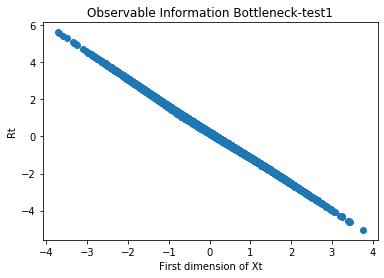

In [7]:
# R = R_net(X0.to(device))
# plt.plot(X0_bar.cpu().detach().numpy()[:, 0], R.cpu().detach().numpy()[:, 0], 'o')
R = R_net(X0)
plt.plot(X0.detach().numpy()[:, 0], R.detach().numpy()[:, 0], 'o')
plt.xlabel('First dimension of Xt')
plt.ylabel('Rt')
plt.title('Observable Information Bottleneck-test1')